In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s11-gradcam.git'
local_dir = '/content/s11-gradcam'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

/content/s11-gradcam
Already up to date.


In [3]:
import sys
sys.path.append('/content/s11-gradcam')
sys.path.append('/content/s11-gradcam/models')
sys.path.append('/content/s11-gradcam/utils')

In [4]:
!pip install torch-lr-finder

In [5]:
from config import get_config
config = get_config()
from main import main,set_seeds,setup_cifar10
import torch
from torch_lr_finder import LRFinder
from models.resnet import ResNet18
from models.model_utils import model_summary, adam_optimizer
import torch.nn.functional as F
from trainer import ModelTrainer
from torch.optim.lr_scheduler import OneCycleLR
set_seeds()

In [6]:
config['epochs'] = 20
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.001

In [7]:
train_data, test_data, train_loader, test_loader = setup_cifar10(config)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = config["device"]
model = ResNet18().to(device)
model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [9]:
criterion = F.cross_entropy
optimizer = adam_optimizer(model, config)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.10E-03


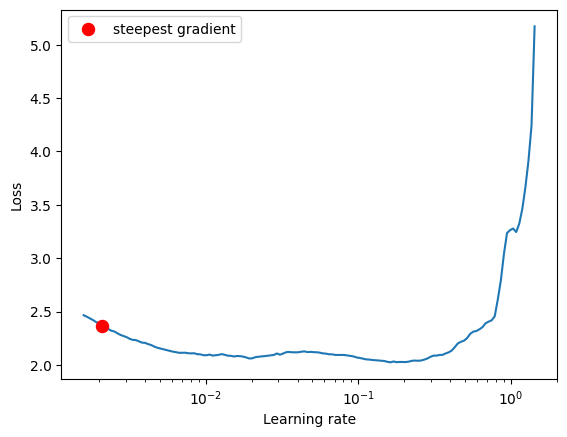

In [10]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [11]:
ocp_scheduler = OneCycleLR(
        optimizer,
        max_lr=2.10E-03,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"],
        pct_start=5 / config["epochs"],
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy="linear")

In [12]:
# Create an instance of the ModelTrainer class
trainer = ModelTrainer(model, device, train_loader, test_loader, optimizer, criterion, ocp_scheduler)

In [13]:
lr = main(config,model,trainer)

EPOCH: 1


Loss=1.3299800157546997 Batch_id=390 Accuracy=39.88: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]

Max Learning Rate: 0.0004370127942681678



Test set: Average loss: 1.8692, Accuracy: 4434/10000 (44.34%)

EPOCH: 2


Loss=1.0045512914657593 Batch_id=390 Accuracy=57.25: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]

Max Learning Rate: 0.0008530255885363355



Test set: Average loss: 1.0962, Accuracy: 6259/10000 (62.59%)

EPOCH: 3


Loss=0.8947468996047974 Batch_id=390 Accuracy=65.61: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]

Max Learning Rate: 0.0012690383828045033



Test set: Average loss: 1.0499, Accuracy: 6549/10000 (65.49%)

EPOCH: 4


Loss=0.8309239149093628 Batch_id=390 Accuracy=70.03: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]

Max Learning Rate: 0.001685051177072671



Test set: Average loss: 0.7918, Accuracy: 7404/10000 (74.04%)

EPOCH: 5


Loss=0.6489930152893066 Batch_id=390 Accuracy=72.72: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]

Max Learning Rate: 0.002099641979539642



Test set: Average loss: 0.7913, Accuracy: 7405/10000 (74.05%)

EPOCH: 6


Loss=0.6344868540763855 Batch_id=390 Accuracy=75.01: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

Max Learning Rate: 0.001959655979539642



Test set: Average loss: 0.6156, Accuracy: 7959/10000 (79.59%)

EPOCH: 7


Loss=0.7385557889938354 Batch_id=390 Accuracy=77.54: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]

Max Learning Rate: 0.0018196699795396418



Test set: Average loss: 0.7015, Accuracy: 7739/10000 (77.39%)

EPOCH: 8


Loss=0.5652540326118469 Batch_id=390 Accuracy=79.20: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]

Max Learning Rate: 0.0016796839795396418



Test set: Average loss: 0.4705, Accuracy: 8343/10000 (83.43%)

EPOCH: 9


Loss=0.5964455008506775 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]

Max Learning Rate: 0.0015396979795396417



Test set: Average loss: 0.6370, Accuracy: 7944/10000 (79.44%)

EPOCH: 10


Loss=0.5323980450630188 Batch_id=390 Accuracy=81.97: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

Max Learning Rate: 0.0013997119795396418



Test set: Average loss: 0.6285, Accuracy: 7955/10000 (79.55%)

EPOCH: 11


Loss=0.3459082543849945 Batch_id=390 Accuracy=82.96: 100%|██████████| 391/391 [00:49<00:00,  7.83it/s]

Max Learning Rate: 0.0012597259795396418



Test set: Average loss: 0.4321, Accuracy: 8580/10000 (85.80%)

EPOCH: 12


Loss=0.3359453082084656 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]

Max Learning Rate: 0.001119739979539642



Test set: Average loss: 0.4193, Accuracy: 8667/10000 (86.67%)

EPOCH: 13


Loss=0.4275406002998352 Batch_id=390 Accuracy=85.07: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

Max Learning Rate: 0.0009797539795396418



Test set: Average loss: 0.4173, Accuracy: 8625/10000 (86.25%)

EPOCH: 14


Loss=0.29991626739501953 Batch_id=390 Accuracy=86.48: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

Max Learning Rate: 0.0008397679795396418



Test set: Average loss: 0.4098, Accuracy: 8672/10000 (86.72%)

EPOCH: 15


Loss=0.4032979905605316 Batch_id=390 Accuracy=87.48: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]

Max Learning Rate: 0.0006997819795396419



Test set: Average loss: 0.3732, Accuracy: 8821/10000 (88.21%)

EPOCH: 16


Loss=0.31994548439979553 Batch_id=390 Accuracy=88.90: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]

Max Learning Rate: 0.000559795979539642



Test set: Average loss: 0.3492, Accuracy: 8898/10000 (88.98%)

EPOCH: 17


Loss=0.2587328553199768 Batch_id=390 Accuracy=90.19: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]

Max Learning Rate: 0.00041980997953964204



Test set: Average loss: 0.3357, Accuracy: 8972/10000 (89.72%)

EPOCH: 18


Loss=0.2883536219596863 Batch_id=390 Accuracy=91.47: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]

Max Learning Rate: 0.0002798239795396421



Test set: Average loss: 0.2794, Accuracy: 9146/10000 (91.46%)

EPOCH: 19


Loss=0.17770078778266907 Batch_id=390 Accuracy=93.06: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]

Max Learning Rate: 0.00013983797953964197



Test set: Average loss: 0.2744, Accuracy: 9182/10000 (91.82%)

EPOCH: 20


Loss=0.3206477165222168 Batch_id=390 Accuracy=94.16: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]

Max Learning Rate: -1.4802046035796226e-07



Test set: Average loss: 0.2640, Accuracy: 9214/10000 (92.14%)



In [25]:
train_losses = trainer.train_losses
test_losses = trainer.test_losses
train_acc = trainer.train_acc
test_acc = trainer.test_acc

[2.5391886234283447, 2.4982998371124268, 2.3282992839813232, 2.351146697998047, 2.363957643508911, 2.395376682281494, 2.3417866230010986, 2.2871737480163574, 2.261538028717041, 2.2596137523651123, 2.238410234451294, 2.229001045227051, 2.2561304569244385, 2.149172067642212, 2.28410267829895, 2.2018375396728516, 2.1397600173950195, 2.14744234085083, 2.1791799068450928, 2.1482937335968018, 2.1902506351470947, 2.1730926036834717, 2.2054831981658936, 2.1462368965148926, 2.1428050994873047, 2.1320033073425293, 2.139403820037842, 2.0988240242004395, 2.0214407444000244, 2.064668655395508, 2.0734944343566895, 2.0759198665618896, 2.1601173877716064, 1.886696696281433, 1.960008978843689, 2.0339794158935547, 1.9807848930358887, 1.9815897941589355, 1.9591988325119019, 1.9603581428527832, 1.9222805500030518, 1.8684961795806885, 1.890222191810608, 1.8315635919570923, 1.8361234664916992, 2.0277326107025146, 1.939911961555481, 1.9479222297668457, 1.8290401697158813, 1.9438135623931885, 1.88132727146148

Text(0.5, 1.0, 'Test Accuracy')

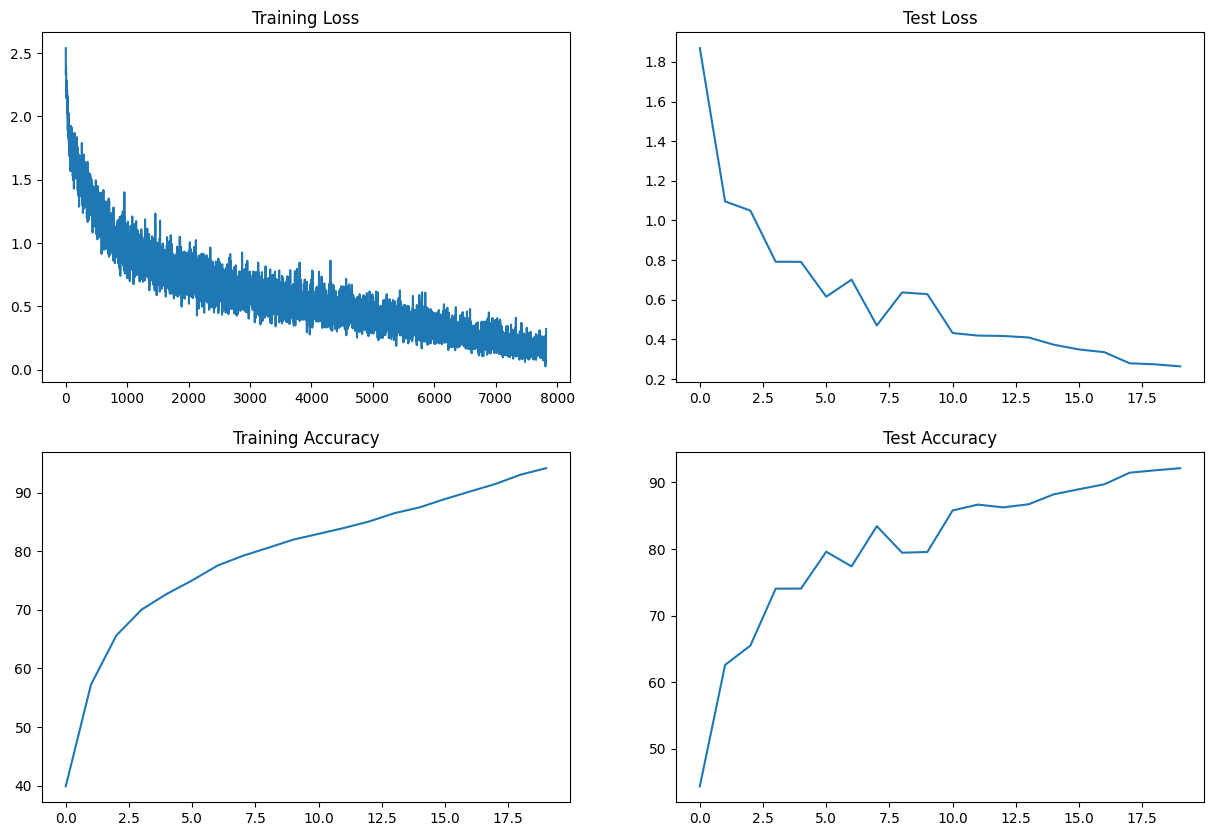

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")